# Supervised Clusering: The Merits of Using SHAP Values for Cluster Analysis

## Set-up

In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from umap import UMAP

In [2]:
plt.style.use("style.mplstyle")
shap.initjs()

### Configure Notebook Parameters

In [3]:
n_clusters_per_class = 3
seed = 1

# for plotting
alpha = 0.5
size = 15

# Simulate Dataset

[`make_classification` docs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification)

In [4]:
np.random.seed(seed)

X, y = make_classification(
    n_samples=1000,
    n_features=50,
    n_informative=5,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=n_clusters_per_class,
    weights=None,
    flip_y=0,
    hypercube=True,
    class_sep=1.9,
    shift=np.random.random(50) * 3 - 1.5,
    scale=np.random.random(50) * 2,
    random_state=seed,
    shuffle=False
)

# Train Supervised Classfication Model

In [5]:
# fit GBT model to all data
m = lgb.LGBMClassifier(random_state=seed)
m.fit(X, y)

LGBMClassifier(random_state=1)

In [6]:
# check model accuracy
y_pred = m.predict(X)
acc = accuracy_score(y, y_pred)
acc

1.0

## Compute SHAP Values

In [7]:
# compute SHAP values using all data
explainer = shap.Explainer(m, random_state=seed)
shap_values = explainer(X)
sv = shap_values.values[:, :, 1]

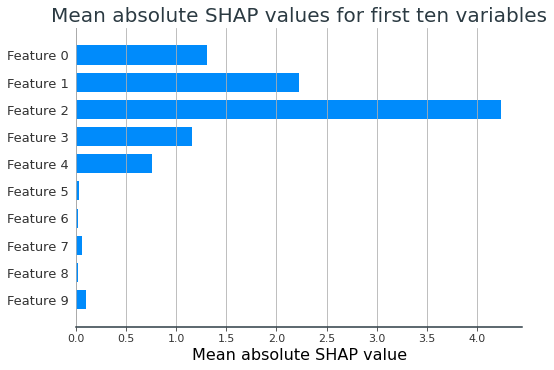

In [8]:
#fig, ax = plt.subplots(figsize=(5.5, 6))
shap.summary_plot(sv, plot_type="bar", sort=False, show=False, max_display=10)
fig, ax = plt.gcf(), plt.gca()
ax.set_title("Mean absolute SHAP values for first ten variables", fontsize=20)
ax.set_xlabel("Mean absolute SHAP value", fontsize=16)
ax.grid(axis="x")
fig.savefig("plots/MASV.png", dpi=75)

## Compare SHAP Values with Raw Values

In [9]:
# prepare data for visualisation
df_sv = pd.DataFrame(sv)
df_sv.columns = [f"feat{n}" for n in range(X.shape[1])]
df_sv["y"] = y
df_sv["variable value"] = "shap"

df_raw = pd.DataFrame(X)
df_raw.columns = [f"feat{n}" for n in range(X.shape[1])]
df_sv["y"] = y
df_raw["variable value"] = "raw"

df_all = pd.concat([df_raw, df_sv], axis=0, ignore_index=True)

# convert to long format
l = pd.melt(
    df_all,
    id_vars=["y", "variable value"],
    value_vars=[f"feat{n}" for n in range(X.shape[1])],
)
l["variable"] = l["variable"].str[4:]

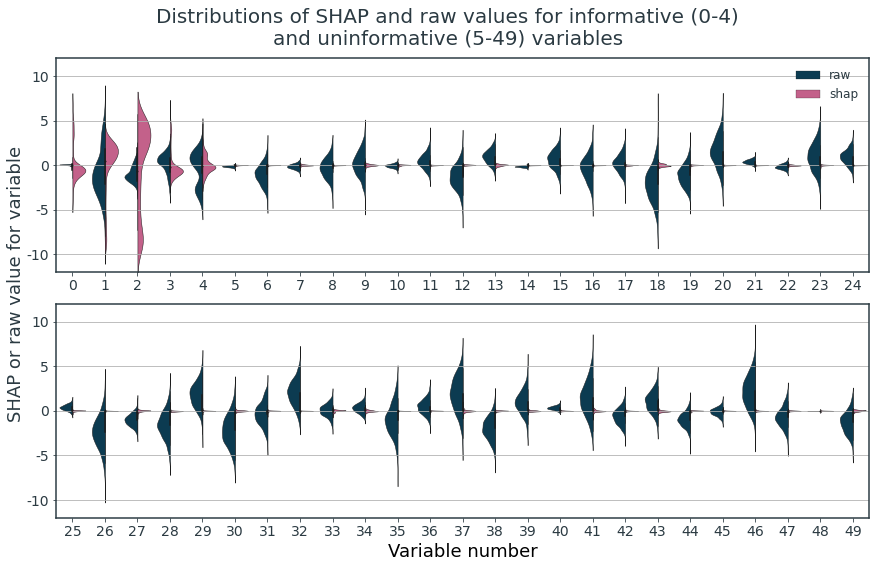

In [10]:
fig, ax = plt.subplots(2, 1)

sns.violinplot(
    x="variable",
    y="value",
    data=l.iloc[:50000],
    hue="variable value",
    ax=ax[0],
    linewidth=0.5,
    split=True,
    scale="width",
)
sns.violinplot(
    x="variable",
    y="value",
    data=l.iloc[50000:],
    hue="variable value",
    ax=ax[1],
    linewidth=0.5,
    split=True,
    scale="width",
)

lim = np.round(l["value"].abs().max()) + 2
for a in (0, 1):
    ax[a].set_ylim(-lim, lim)
    ax[a].grid(axis="y")
    ax[a].set_xlabel("")
    ax[a].set_ylabel("")
    ax[a].legend().remove()
ax[1].set_xlabel("Variable number")
ax[0].legend()

fig.text(
    -0.01,
    0.5,
    "SHAP or raw value for variable",
    va="center",
    rotation="vertical",
    fontsize=18,
)
fig.suptitle(
    "Distributions of SHAP and raw values for informative (0-4)\nand uninformative (5-49) variables",
    fontsize=20,
)
fig.tight_layout()

fig.savefig("plots/distributions.png")

# Dimensionality Reduction

## Using Raw Values

In [11]:
# for class colours in scatter plots
c = ["#d45087"] * len(y)  # pink
for i in range(len(y)):
    if y[i] == 1:
        c[i] = "#003f5c"  # blue

In [12]:
# compute 2D embedding of raw variable values using UMAP
X_2d = UMAP(
    n_components=2,
    n_neighbors=200,
    min_dist=0,
    random_state=seed,
).fit_transform(X)

The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11002. The TBB threading layer is disabled.


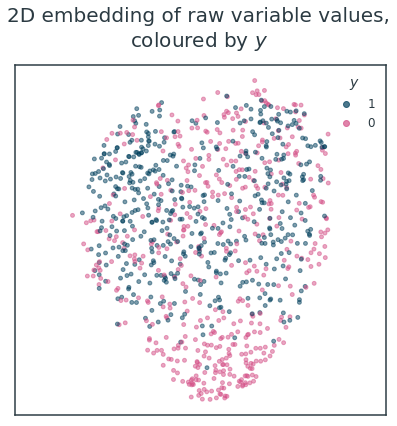

In [13]:
fig, ax = plt.subplots(figsize=(5.5, 6))
sns.regplot(
    x="A",
    y="B",
    data=pd.DataFrame(X_2d, columns=["A", "B"]),
    fit_reg=False,
    ax=ax,
    scatter_kws={"alpha": alpha, "s": size, "color": c},
)

# equalise axes and hacky solution for legend
ax.axis("equal")
x, y = ax.get_xlim(), ax.get_ylim()
ax.scatter([99], [99], label="1", alpha=0.7)
ax.scatter([99], [99], label="0", alpha=0.7)
ax.legend(title="$y$", title_fontsize=14)
ax.set_xlim(x)
ax.set_ylim(y)

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.set_yticks([])

fig.suptitle(
    "2D embedding of raw variable values,\ncoloured by $y$",
    fontsize=20,
)
fig.tight_layout()

fig.savefig("plots/2D_raw.png", dpi=75)

## Using SHAP Values

In [14]:
# compute 2D embedding of SHAP variable values using UMAP
sv_2d = UMAP(
    n_components=2,
    n_neighbors=200,
    min_dist=0,
    random_state=seed,
).fit_transform(sv)

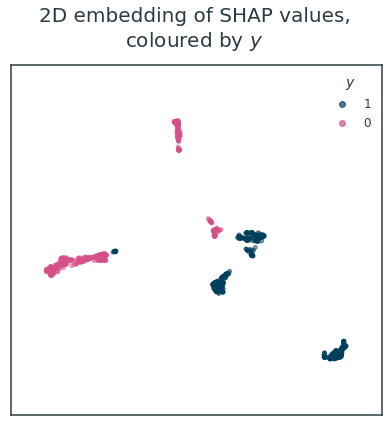

In [15]:
fig, ax = plt.subplots(figsize=(5.5, 6))
sns.regplot(
    x="A",
    y="B",
    data=pd.DataFrame(sv_2d, columns=["A", "B"]),
    fit_reg=False,
    ax=ax,
    scatter_kws={"alpha": alpha, "s": size, "color": c},
)

# equalise axes and hacky solution for legend
ax.axis("equal")
x, y = ax.get_xlim(), ax.get_ylim()
ax.scatter([99], [99], label="1", alpha=0.7)
ax.scatter([99], [99], label="0", alpha=0.7)
ax.legend(title="$y$", title_fontsize=14)
ax.set_xlim(x)
ax.set_ylim(y)

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.set_yticks([])

fig.suptitle(
    "2D embedding of SHAP values,\ncoloured by $y$",
    fontsize=20,
)
fig.tight_layout()

fig.savefig("plots/2D_SHAP.png", dpi=75)

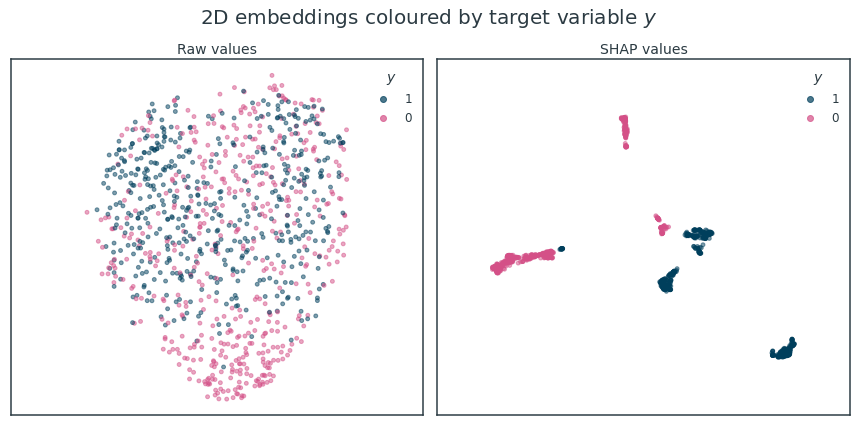

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for data, ax, label in zip([X_2d, sv_2d], axes, ["Raw values", "SHAP values"]): 
    sns.regplot(
        x="A",
        y="B",
        data=pd.DataFrame(data, columns=["A", "B"]),
        fit_reg=False,
        ax=ax,
        scatter_kws={"alpha": alpha, "s": size, "color": c},
    )

    # equalise axes and hacky solution for legend
    ax.axis("equal")
    x, y = ax.get_xlim(), ax.get_ylim()
    ax.scatter([99], [99], label="1", alpha=0.7)
    ax.scatter([99], [99], label="0", alpha=0.7)
    ax.legend(title="$y$", title_fontsize=14)
    ax.set_xlim(x)
    ax.set_ylim(y)

    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(label, fontsize=14)

fig.suptitle(
    "2D embeddings coloured by target variable $y$",
    fontsize=20,
)
fig.tight_layout()

fig.savefig("plots/2D_raw_and SHAP.png")

# Clustering

In [17]:
# Identify clusters using DBSCAN
sv_2d_labels = DBSCAN(eps=1.5, min_samples=20).fit(sv_2d).labels_

In [18]:
# for each cluster identified, check count and central coordinates of cluster
for cluster, count in pd.Series(sv_2d_labels).value_counts().sort_index().items():
    print(cluster, count, sv_2d[sv_2d_labels == cluster].mean(0))

0 129 [ 8.597724 15.34596 ]
1 61 [11.641199  7.128071]
2 327 [-0.15917726  4.2434287 ]
3 188 [14.991733   6.1383224]
4 149 [22.218035  -3.5457027]
5 146 [12.163431   2.3517752]


In [19]:
# for mapping cluster integers to descriptive labels
label_dict = {
    0: "2_(y=0)",
    1: "3_(y=0)",
    2: "1_(y=0)",
    3: "1_(y=1)",
    4: "3_(y=1)",
    5: "2_(y=2)"
}

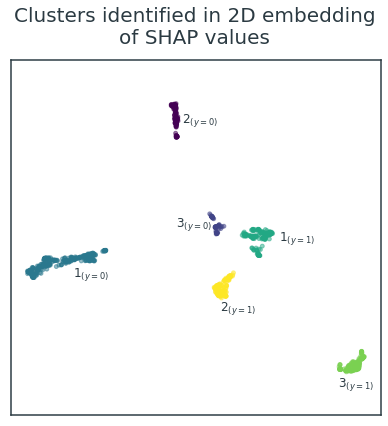

In [20]:
fig, ax = plt.subplots(figsize=(5.5, 6))
ax.scatter(sv_2d[:, 0], sv_2d[:, 1], c=sv_2d_labels, s=size, alpha=alpha)
ax.axis("equal")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.set_yticks([])
ax.annotate(r"$1_{(y=0)}$", (0.8, 3.2), fontsize=12)
ax.annotate(r"$2_{(y=0)}$", (9.1, 15), fontsize=12)
ax.annotate(r"$3_{(y=0)}$", (8.6, 7), fontsize=12)
ax.annotate(r"$1_{(y=1)}$", (16.5, 6), fontsize=12)
ax.annotate(r"$2_{(y=1)}$", (12, 0.6), fontsize=12)
ax.annotate(r"$3_{(y=1)}$", (21, -5.2), fontsize=12)

fig.suptitle(
    "Clusters identified in 2D embedding\nof SHAP values",
    fontsize=20,
)
fig.tight_layout()

fig.savefig("plots/2D_SHAP_clusters.png", dpi=75)

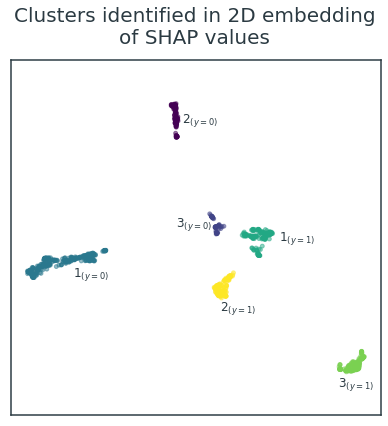

In [21]:
fig, ax = plt.subplots(figsize=(5.5, 6))
ax.scatter(sv_2d[:, 0], sv_2d[:, 1], c=sv_2d_labels, s=size, alpha=alpha)
ax.axis("equal")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.set_yticks([])
ax.annotate(r"$1_{(y=0)}$", (0.8, 3.2), fontsize=12)
ax.annotate(r"$2_{(y=0)}$", (9.1, 15), fontsize=12)
ax.annotate(r"$3_{(y=0)}$", (8.6, 7), fontsize=12)
ax.annotate(r"$1_{(y=1)}$", (16.5, 6), fontsize=12)
ax.annotate(r"$2_{(y=1)}$", (12, 0.6), fontsize=12)
ax.annotate(r"$3_{(y=1)}$", (21, -5.2), fontsize=12)

fig.suptitle(
    "Clusters identified in 2D embedding\nof SHAP values",
    fontsize=20,
)
fig.tight_layout()

fig.savefig("plots/2D_SHAP_clusters_feature.png", dpi=300)

## SHAP Embedding Clusters Coloured by Raw Variable Values

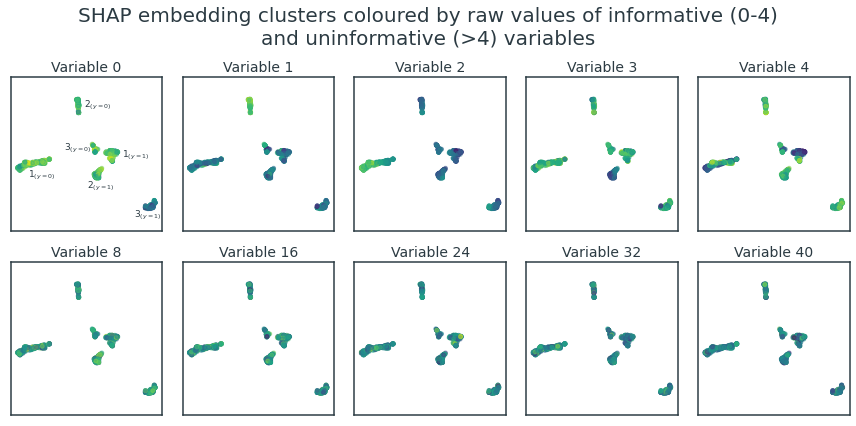

In [22]:
vs = [0, 1, 2, 3, 4, 8, 16, 24, 32, 40]

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for ax, v in zip(axes, vs):
    im = ax.scatter(sv_2d[:, 0], sv_2d[:, 1], c=X[:, v], s=size, alpha=alpha)
    ax.axis("equal")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Variable {v}", fontsize=14)
    
    if v == 0:
        ax.annotate(r"$1_{(y=0)}$", (-0.8, 2), fontsize=9)
        ax.annotate(r"$2_{(y=0)}$", (9.6, 15), fontsize=9)
        ax.annotate(r"$3_{(y=0)}$", (6, 7), fontsize=9)
        ax.annotate(r"$1_{(y=1)}$", (16.7, 5.7), fontsize=9)
        ax.annotate(r"$2_{(y=1)}$", (10.3, -0.2), fontsize=9)
        ax.annotate(r"$3_{(y=1)}$", (19, -5.5), fontsize=9)


fig.suptitle(
    "SHAP embedding clusters coloured by raw values of informative (0-4)\nand uninformative (>4) variables",
    fontsize=20,
)
fig.tight_layout()

fig.savefig("plots/2D_SHAP_clusters_coloured_by_raw_values.png")

# Cluster Descriptions

In [23]:
# work around for skrules import error
import six
import sys
sys.modules['sklearn.externals.six'] = six
from skrules import SkopeRules

In [24]:
df_X = df_raw.drop("variable value", axis=1)

In [25]:
def skoperules_models(
    X: pd.DataFrame,
    y: np.array,
    labels: np.array,
    n_estimators: int = 10,
    recall_min: float = 0.2,
    max_depth: int = 2,
    max_depth_duplication: int = 4,
    max_samples: float = 1.0,
    random_state: int = seed,
):
    X["cluster"] = labels
    sr_models = {}
    for cluster in X["cluster"].value_counts().index.sort_values():
        Xc = X.drop("cluster", axis=1)
        yc = (X["cluster"] == cluster) * 1
        sr = SkopeRules(
            feature_names=Xc.columns,
            random_state=random_state,
            n_estimators=n_estimators,
            recall_min=recall_min,
            max_depth=max_depth,
            max_depth_duplication=max_depth_duplication,
            max_samples=max_samples,
            max_features=None
        )
        sr.fit(Xc, yc)
        sr_models[cluster] = sr
    return sr_models

In [26]:
sv_models = skoperules_models(df_X, y, sv_2d_labels)

In [27]:
for cluster in sv_models.keys():
    print(f"Cluster {label_dict[cluster]}")
    if len(sv_models[cluster].rules_) == 0:
        print("N/A")
    else:
        for i, rule in enumerate(sv_models[cluster].rules_):
            if i == 0:
                for line in rule[0].split(" and "):
                    print(f"\t{line}")
                print(f"Precision: {rule[1][0]:.4f}")
                print(f"Recall   : {rule[1][1]:.4f}")
    print()

Cluster 2_(y=0)
	feat1 > 2.3398897647857666
	feat4 > -1.4165911078453064
Precision: 0.9843
Recall   : 0.9690

Cluster 3_(y=0)
	feat0 > 0.12441839650273323
	feat2 <= -0.7795118987560272
Precision: 0.5366
Recall   : 0.3607

Cluster 1_(y=0)
	feat0 > -0.050614044070243835
	feat2 > -0.7123425304889679
Precision: 0.9284
Recall   : 0.9908

Cluster 1_(y=1)
	feat2 <= -0.7569182813167572
	feat4 <= -1.619143009185791
Precision: 0.9308
Recall   : 0.7872

Cluster 3_(y=1)
	feat0 <= -0.041219551116228104
	feat3 > -2.1033881306648254
Precision: 0.9577
Recall   : 0.9128

Cluster 2_(y=2)
	feat3 <= -0.8852411806583405
	feat4 > -1.5127198696136475
Precision: 0.9209
Recall   : 0.8767

